# Dataset Loading from Kaggle

In [1]:
from google.colab import files
files.upload()  # upload kaggle.json here



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahonsideborah","key":"99000b4bcbd7dff80e250442c17071f2"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d claytonmiller/buildingdatagenomeproject2

Dataset URL: https://www.kaggle.com/datasets/claytonmiller/buildingdatagenomeproject2
License(s): CC-BY-SA-4.0
 85% 223M/263M [00:00<00:00, 559MB/s] 
100% 263M/263M [00:00<00:00, 537MB/s]


In [4]:
import zipfile

with zipfile.ZipFile('buildingdatagenomeproject2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/bdg2_data')


# Data PreProcessing

In [5]:
import os
os.listdir('/content/bdg2_data')


['hotwater.csv',
 'irrigation_cleaned.csv',
 'hotwater_cleaned.csv',
 'water_cleaned.csv',
 'gas_cleaned.csv',
 'electricity.csv',
 'steam_cleaned.csv',
 'steam.csv',
 'irrigation.csv',
 'solar_cleaned.csv',
 'electricity_cleaned.csv',
 'chilledwater.csv',
 'gas.csv',
 'metadata.csv',
 'solar.csv',
 'weather.csv',
 'chilledwater_cleaned.csv',
 'water.csv']

In [6]:
import pandas as pd

base_path = '/content/bdg2_data/'

electricity = pd.read_csv(base_path + 'electricity_cleaned.csv', parse_dates=['timestamp'])
weather = pd.read_csv(base_path + 'weather.csv', parse_dates=['timestamp'])
metadata = pd.read_csv(base_path + 'metadata.csv')


In [7]:
df = pd.read_csv('bdg2_data/electricity_cleaned.csv', parse_dates=['timestamp'])
df_long = df.melt(id_vars='timestamp', var_name='building_id', value_name='value')

In [8]:
df_long = df_long.merge(metadata[['building_id', 'site_id']], on='building_id', how='left')
print(metadata.columns)

Index(['building_id', 'site_id', 'building_id_kaggle', 'site_id_kaggle',
       'primaryspaceusage', 'sub_primaryspaceusage', 'sqm', 'sqft', 'lat',
       'lng', 'timezone', 'electricity', 'hotwater', 'chilledwater', 'steam',
       'water', 'irrigation', 'solar', 'gas', 'industry', 'subindustry',
       'heatingtype', 'yearbuilt', 'date_opened', 'numberoffloors',
       'occupants', 'energystarscore', 'eui', 'site_eui', 'source_eui',
       'leed_level', 'rating'],
      dtype='object')


In [9]:
print(df_long['building_id'].head())
print(metadata['building_id'].head())


0    Panther_parking_Lorriane
1    Panther_parking_Lorriane
2    Panther_parking_Lorriane
3    Panther_parking_Lorriane
4    Panther_parking_Lorriane
Name: building_id, dtype: object
0         Panther_lodging_Dean
1       Panther_lodging_Shelia
2        Panther_lodging_Ricky
3    Panther_education_Rosalie
4      Panther_education_Misty
Name: building_id, dtype: object


In [10]:
import pandas as pd

# Load data
electricity = pd.read_csv('bdg2_data/electricity_cleaned.csv', parse_dates=['timestamp'])
metadata = pd.read_csv('bdg2_data/metadata.csv')
weather = pd.read_csv('bdg2_data/weather.csv', parse_dates=['timestamp'])

top_5_buildings = ['Hog_office_Lizzie', 'Hog_education_Jewel', 'Hog_public_Octavia',
                   'Hog_lodging_Francisco', 'Hog_assembly_Dona']

# Step 2: Filter electricity data
electricity_subset = electricity[['timestamp'] + top_5_buildings]

# Step 3: Melt to long format
df_long = electricity_subset.melt(id_vars='timestamp', var_name='building_id', value_name='value')

# Step 4: Merge with metadata to get site_id
df_long = df_long.merge(metadata[['building_id', 'site_id']], on='building_id', how='left')

# Step 5: Merge with weather data on timestamp and site_id
df_long = df_long.merge(weather, on=['timestamp', 'site_id'], how='left')

# Final check
print(df_long.head())


            timestamp        building_id   value site_id  airTemperature  \
0 2016-01-01 00:00:00  Hog_office_Lizzie  42.335     Hog            -7.2   
1 2016-01-01 01:00:00  Hog_office_Lizzie  42.335     Hog            -6.7   
2 2016-01-01 02:00:00  Hog_office_Lizzie  41.689     Hog            -6.7   
3 2016-01-01 03:00:00  Hog_office_Lizzie  45.414     Hog            -6.7   
4 2016-01-01 04:00:00  Hog_office_Lizzie  44.866     Hog            -8.3   

   cloudCoverage  dewTemperature  precipDepth1HR  precipDepth6HR  \
0            8.0           -10.6             0.0            -1.0   
1            NaN           -10.0            -1.0             NaN   
2            NaN            -9.4             0.0             NaN   
3            NaN            -9.4            -1.0             NaN   
4            NaN           -11.7             0.0             NaN   

   seaLvlPressure  windDirection  windSpeed  
0          1022.9          280.0        5.7  
1          1022.5          280.0        4.

In [11]:
df_long = df_long.dropna(subset=['value'])
df_long = df_long.fillna(method='ffill')
print(df_long.columns.tolist())


['timestamp', 'building_id', 'value', 'site_id', 'airTemperature', 'cloudCoverage', 'dewTemperature', 'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'windSpeed']


/tmp/ipython-input-1989441514.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_long = df_long.fillna(method='ffill')


In [12]:
df_long['date'] = pd.to_datetime(df_long['timestamp']).dt.date

In [13]:
daily_df = df_long.groupby(['building_id', 'date']).agg({
    'value': 'sum',
    'airTemperature': 'mean',
    'dewTemperature': 'mean',
    'precipDepth1HR': 'sum',
    'windSpeed': 'mean',
    'seaLvlPressure': 'mean'
}).reset_index()


In [14]:
# Convert date back to datetime
daily_df['date'] = pd.to_datetime(daily_df['date'])

# Sort before creating lag/rolling features
daily_df = daily_df.sort_values(['building_id', 'date'])

# Create time and lag features
def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    df['lag_1'] = df.groupby('building_id')['value'].shift(1)
    df['lag_7'] = df.groupby('building_id')['value'].shift(7)
    df['rolling_mean_7'] = df.groupby('building_id')['value'].shift(1).rolling(7).mean().reset_index(0, drop=True)
    df['rolling_std_7'] = df.groupby('building_id')['value'].shift(1).rolling(7).std().reset_index(0, drop=True)

    return df

daily_df = create_features(daily_df)
daily_df = daily_df.dropna()


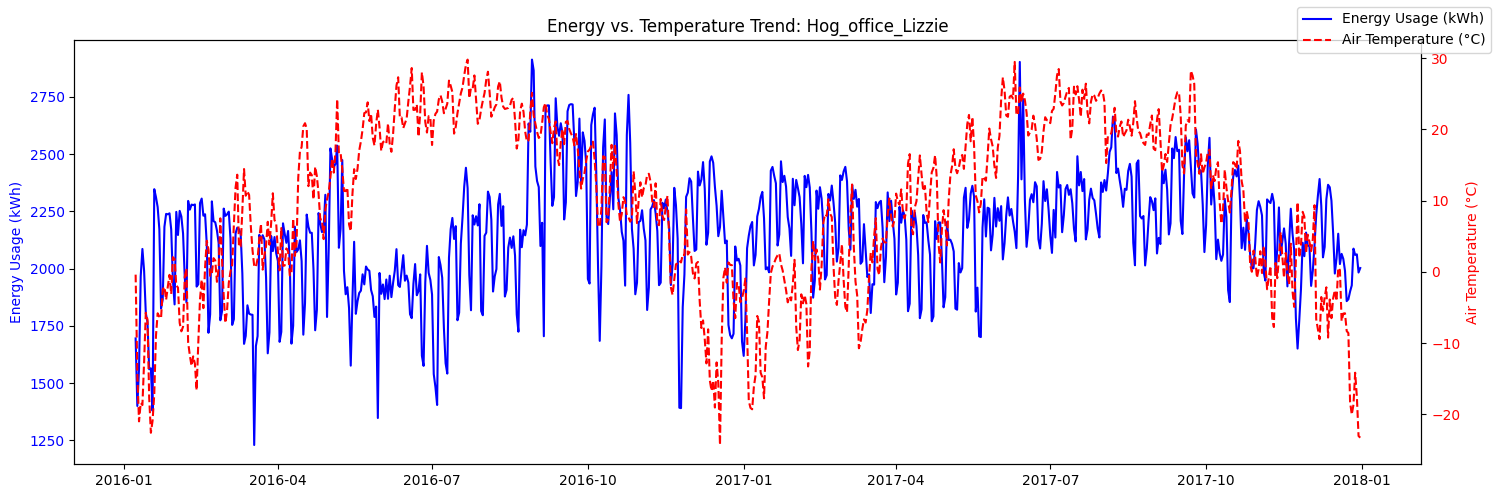

In [15]:
import matplotlib.pyplot as plt

# Choose a building to visualize
building = 'Hog_office_Lizzie'
plot_df = daily_df[daily_df['building_id'] == building]

# Set up the plot
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot energy usage (primary y-axis)
ax1.plot(plot_df['date'], plot_df['value'], color='blue', label='Energy Usage (kWh)')
ax1.set_ylabel('Energy Usage (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot temperature on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(plot_df['date'], plot_df['airTemperature'], color='red', linestyle='--', label='Air Temperature (°C)')
ax2.set_ylabel('Air Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Titles and legends
plt.title(f'Energy vs. Temperature Trend: {building}')
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()


#LSTM Modelling

In [16]:
features = [
    'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7',
    'dayofweek', 'month',
    'airTemperature', 'dewTemperature', 'precipDepth1HR',
    'windSpeed', 'seaLvlPressure'
]
target = 'value'


In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Drop NaNs
df_lstm = daily_df[features + [target]].dropna()

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])



In [18]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])  # all features
        y.append(data[i+sequence_length, -1])     # target
    return np.array(X), np.array(y)

sequence_length = 14
X, y = create_sequences(scaled_df.values, sequence_length)


In [19]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [20]:
# df_long has your merged electricity + weather data
top5_buildings = (
    df_long.groupby('building_id')['value']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)


In [21]:
!pip install tensorflow

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define features and target
features = [
    'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7',
    'dayofweek', 'month',
    'airTemperature', 'dewTemperature', 'precipDepth1HR',
    'windSpeed', 'seaLvlPressure'
]
target = 'value'

# Function to prepare data for LSTM
def prepare_lstm_data(df, features, target, window=14):
    df = df.dropna(subset=features + [target])
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[features + [target]])
    X, y = [], []
    for i in range(window, len(scaled)):
        X.append(scaled[i-window:i, :-1])
        y.append(scaled[i, -1])
    return np.array(X), np.array(y), scaler

# Dictionary to store results
lstm_results = []

# Loop over top 5 buildings
top5 = df_long['building_id'].value_counts().index[:5]

for bld in top5:
    df_b = df_long[df_long['building_id'] == bld].copy()

    # Feature engineering
    df_b = df_b.sort_values('timestamp')
    df_b['dayofweek'] = df_b['timestamp'].dt.dayofweek
    df_b['month'] = df_b['timestamp'].dt.month
    df_b['lag_1'] = df_b['value'].shift(1)
    df_b['lag_7'] = df_b['value'].shift(7)
    df_b['rolling_mean_7'] = df_b['value'].rolling(7).mean()
    df_b['rolling_std_7'] = df_b['value'].rolling(7).std()

    # Prepare data
    df_b = df_b.dropna()
    X, y, scaler = prepare_lstm_data(df_b, features, target)

    # Train/test split
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build model
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    # Train
    model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=32, verbose=0, callbacks=[early_stop])

    # Predict and inverse transform
    y_pred = model.predict(X_test)

    # Only inverse transform the target column
    dummy_input = np.zeros((len(y_pred), len(features)+1))
    dummy_input[:, -1] = y_pred[:, 0]
    y_pred_inv = scaler.inverse_transform(dummy_input)[:, -1]

    dummy_input[:, -1] = y_test
    y_test_inv = scaler.inverse_transform(dummy_input)[:, -1]

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    lstm_results.append({
        'building': bld,
        'rmse_lstm': rmse,
        'mae_lstm': mae
    })

# Convert results to DataFrame
lstm_df = pd.DataFrame(lstm_results)
print(lstm_df)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
                building  rmse_lstm   mae_lstm
0      Hog_office_Lizzie   8.725531   6.127176
1    Hog_education_Jewel   5.181375   3.694975
2     Hog_public_Octavia   9.943279   6.783339
3  Hog_lodging_Francisco  13.570164   9.593288
4      Hog_assembly_Dona  42.585958  32.816623


**To prepare actual and predicted Values for deployment later on in the project**

In [23]:
df_predictions = []

for bld in top5:
    df_b = df_long[df_long['building_id'] == bld].copy()

    # Feature engineering
    df_b = df_b.sort_values('timestamp')
    df_b['dayofweek'] = df_b['timestamp'].dt.dayofweek
    df_b['month'] = df_b['timestamp'].dt.month
    df_b['lag_1'] = df_b['value'].shift(1)
    df_b['lag_7'] = df_b['value'].shift(7)
    df_b['rolling_mean_7'] = df_b['value'].rolling(7).mean()
    df_b['rolling_std_7'] = df_b['value'].rolling(7).std()
    df_b = df_b.dropna()

    # Prepare data
    X, y, scaler = prepare_lstm_data(df_b, features, target)

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    timestamps = df_b['timestamp'].iloc[-len(y_test):].reset_index(drop=True)

    # Build and train model
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=32, verbose=0, callbacks=[early_stop])

    # Predict and inverse transform
    y_pred = model.predict(X_test)
    dummy_input = np.zeros((len(y_pred), len(features)+1))
    dummy_input[:, -1] = y_pred[:, 0]
    y_pred_inv = scaler.inverse_transform(dummy_input)[:, -1]

    dummy_input[:, -1] = y_test
    y_test_inv = scaler.inverse_transform(dummy_input)[:, -1]

    # Store results
    building_df = pd.DataFrame({
        'timestamp': timestamps,
        'building': bld,
        'actual': y_test_inv,
        'predicted': y_pred_inv
    })

    df_predictions.append(building_df)

# Concatenate all building predictions
df_predictions = pd.concat(df_predictions, ignore_index=True)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


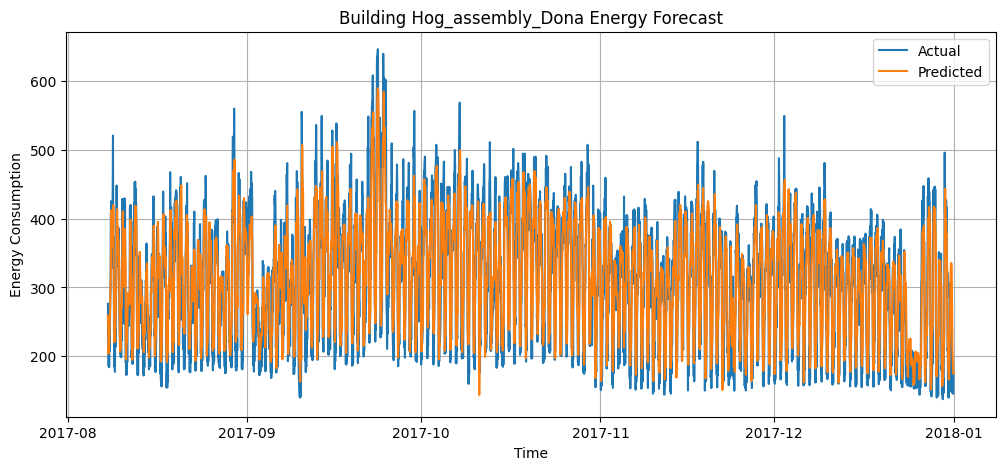

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(timestamps, y_test_inv, label='Actual')
plt.plot(timestamps, y_pred_inv, label='Predicted')
plt.title(f'Building {bld} Energy Forecast')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
print(df_predictions.head(20))

             timestamp           building   actual   predicted
0  2017-08-07 23:00:00  Hog_office_Lizzie  120.380  105.394318
1  2017-08-08 00:00:00  Hog_office_Lizzie  114.813   95.099378
2  2017-08-08 01:00:00  Hog_office_Lizzie   76.627   73.625872
3  2017-08-08 02:00:00  Hog_office_Lizzie   70.547   53.905730
4  2017-08-08 03:00:00  Hog_office_Lizzie   69.756   54.155720
5  2017-08-08 04:00:00  Hog_office_Lizzie   70.122   58.590583
6  2017-08-08 05:00:00  Hog_office_Lizzie   67.551   60.701674
7  2017-08-08 06:00:00  Hog_office_Lizzie   69.667   65.442638
8  2017-08-08 07:00:00  Hog_office_Lizzie   88.964   76.970115
9  2017-08-08 08:00:00  Hog_office_Lizzie  106.711   92.752986
10 2017-08-08 09:00:00  Hog_office_Lizzie  118.239  103.333059
11 2017-08-08 10:00:00  Hog_office_Lizzie  125.739  114.625595
12 2017-08-08 11:00:00  Hog_office_Lizzie  133.559  124.068962
13 2017-08-08 12:00:00  Hog_office_Lizzie  134.499  131.864603
14 2017-08-08 13:00:00  Hog_office_Lizzie  132.300  135

In [26]:
import plotly.express as px

# Select one building for demo
selected_building = 'Hog_office_Lizzie'
df_plot = df_predictions[df_predictions['building'] == selected_building]

fig = px.line(df_plot, x='timestamp', y=['actual', 'predicted'],
              title=f'Actual vs Predicted Energy Usage - {selected_building}',
              labels={'value': 'Energy (kWh)', 'timestamp': 'Date'})

fig.update_traces(mode='lines')
fig.update_layout(legend_title_text='Legend')
fig.show()


In [27]:
# Select unique rows for weather data to avoid duplication
weather_cols = ['timestamp', 'building_id', 'airTemperature', 'dewTemperature', 'windSpeed', 'seaLvlPressure', 'precipDepth1HR']

weather_features_df = df_long[weather_cols].drop_duplicates(subset=['timestamp', 'building_id'])


In [28]:
df_predictions['building_id'] = df_predictions['building']


In [29]:
# Merge weather features into the prediction dataframe
df_predictions = df_predictions.merge(
    weather_features_df,
    on=['timestamp', 'building_id'],
    how='left'
)

df_predictions.drop(columns='building_id', inplace=True)


In [30]:
print(df_predictions.head())

            timestamp           building   actual   predicted  airTemperature  \
0 2017-08-07 23:00:00  Hog_office_Lizzie  120.380  105.394318            20.0   
1 2017-08-08 00:00:00  Hog_office_Lizzie  114.813   95.099378            20.0   
2 2017-08-08 01:00:00  Hog_office_Lizzie   76.627   73.625872            18.9   
3 2017-08-08 02:00:00  Hog_office_Lizzie   70.547   53.905730            18.9   
4 2017-08-08 03:00:00  Hog_office_Lizzie   69.756   54.155720            17.8   

   dewTemperature  windSpeed  seaLvlPressure  precipDepth1HR  
0            12.8        0.0          1020.9             0.0  
1            13.3        1.5          1021.1             0.0  
2            13.3        1.5          1021.2             0.0  
3            13.3        0.0          1021.0             0.0  
4            13.3        0.0          1020.9             0.0  


# Isolation Forest Anomaly detection

In [31]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select a building (e.g., 'Hog_office_Lizzie')
building = 'Hog_office_Lizzie'
df_building = daily_df[daily_df['building_id'] == building].copy()

# Drop NA
df_building.dropna(inplace=True)

# Features to use
features = [
    'value', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7',
    'dayofweek', 'month',
    'airTemperature', 'dewTemperature', 'precipDepth1HR',
    'windSpeed', 'seaLvlPressure'
]

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(df_building[features])

# Apply Isolation Forest
iso = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
df_building['anomaly'] = iso.fit_predict(X)  # -1 = anomaly, 1 = normal


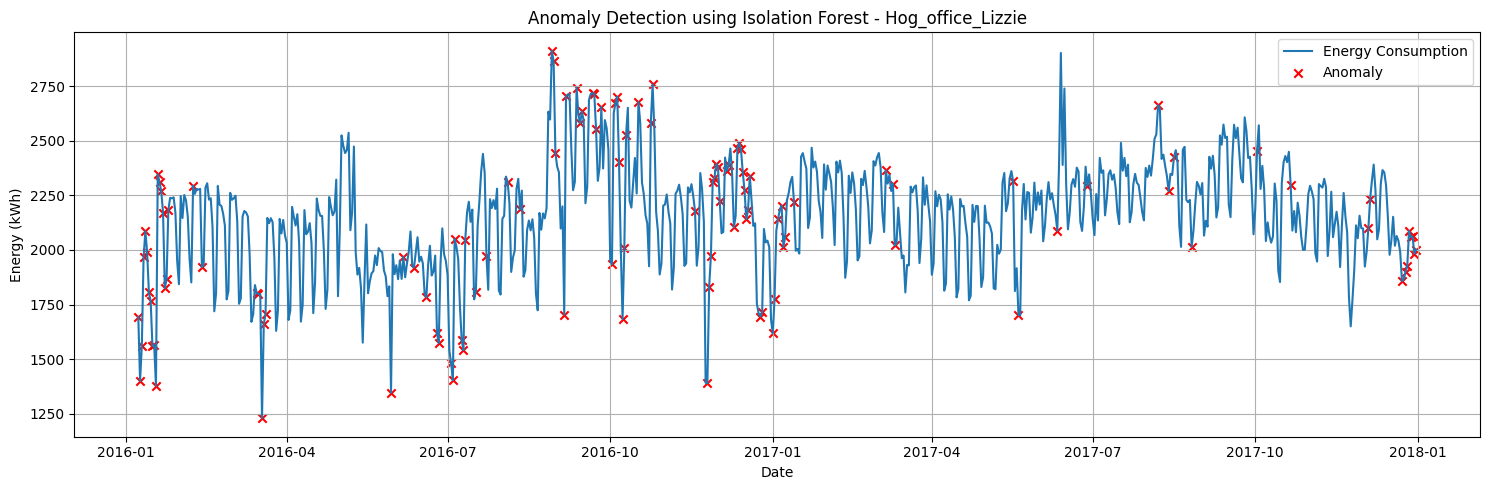

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df_building['date'], df_building['value'], label='Energy Consumption')
plt.scatter(
    df_building[df_building['anomaly'] == -1]['date'],
    df_building[df_building['anomaly'] == -1]['value'],
    color='red', label='Anomaly', marker='x'
)
plt.title(f"Anomaly Detection using Isolation Forest - {building}")
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Create summary list
summary = []

# Use same top 5 buildings
top_5_buildings = ['Hog_office_Lizzie', 'Hog_education_Jewel', 'Hog_public_Octavia',
                   'Hog_lodging_Francisco', 'Hog_assembly_Dona']

for building_id in top_5_buildings:
    building_df = daily_df[daily_df['building_id'] == building_id].dropna()

    # Select features for anomaly detection
    feature_cols = ['value', 'airTemperature', 'dewTemperature', 'windSpeed', 'seaLvlPressure']
    X = building_df[feature_cols]

    # Apply Isolation Forest
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=40)
    preds = iso_forest.fit_predict(X)
    building_df['anomaly'] = (preds == -1).astype(int)

    # Summarize
    total_days = len(building_df)
    anomaly_days = building_df['anomaly'].sum()
    anomaly_rate = round((anomaly_days / total_days) * 100, 2)

    summary.append({
        'Building': building_id,
        'Total Days': total_days,
        'Anomalies Detected': anomaly_days,
        'Anomaly Rate (%)': anomaly_rate
    })

# Create DataFrame
summary_df = pd.DataFrame(summary)

# Display the summary
print(summary_df)


                Building  Total Days  Anomalies Detected  Anomaly Rate (%)
0      Hog_office_Lizzie         724                 107             14.78
1    Hog_education_Jewel         724                 116             16.02
2     Hog_public_Octavia         724                 135             18.65
3  Hog_lodging_Francisco         724                 128             17.68
4      Hog_assembly_Dona         724                 108             14.92


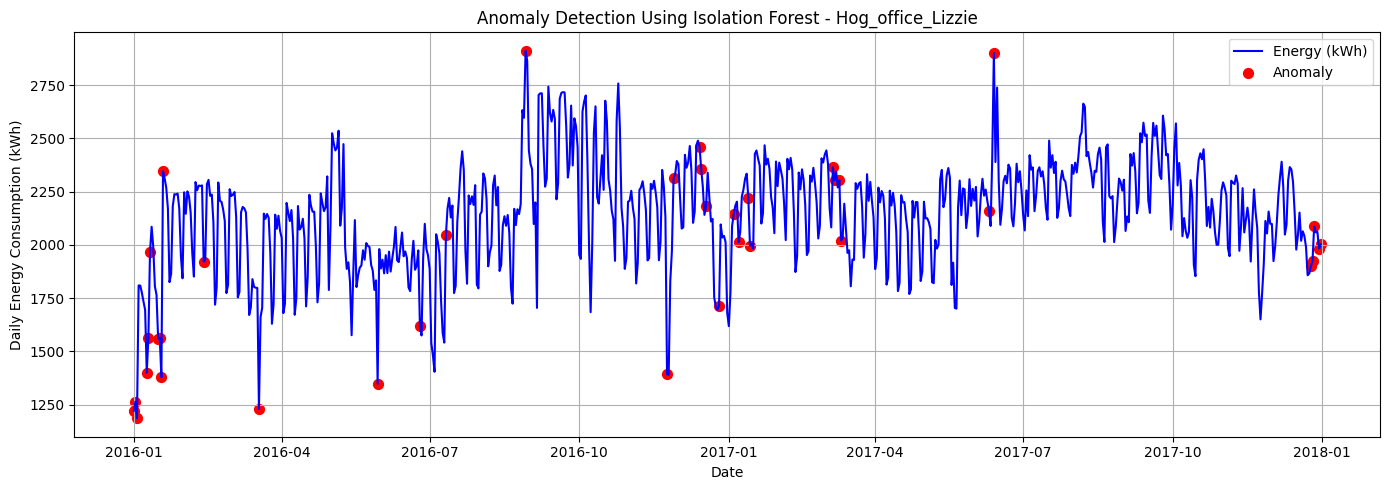

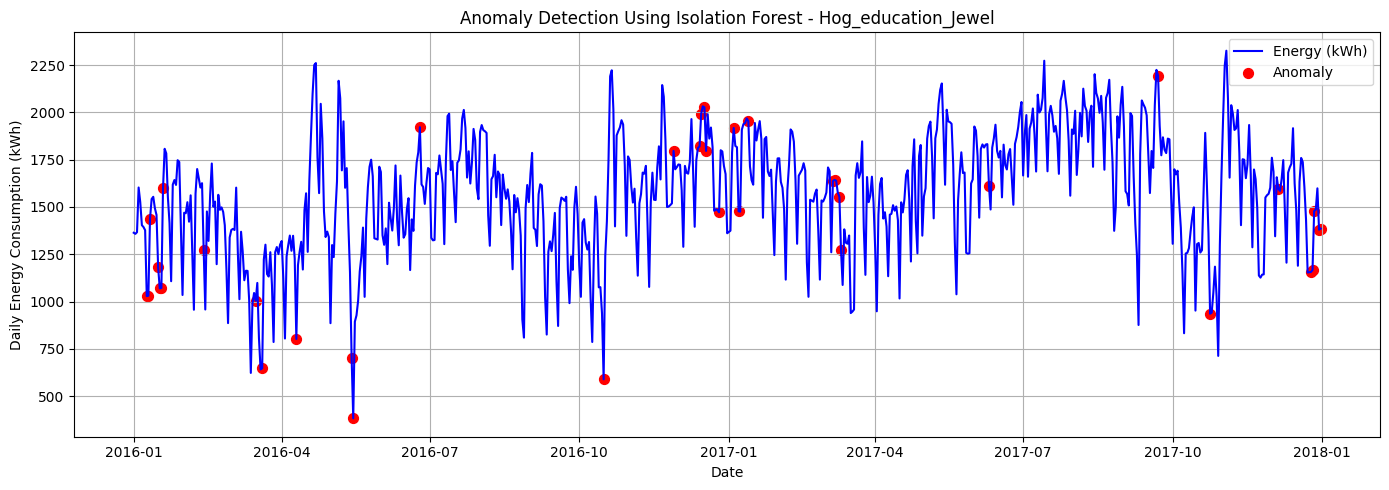

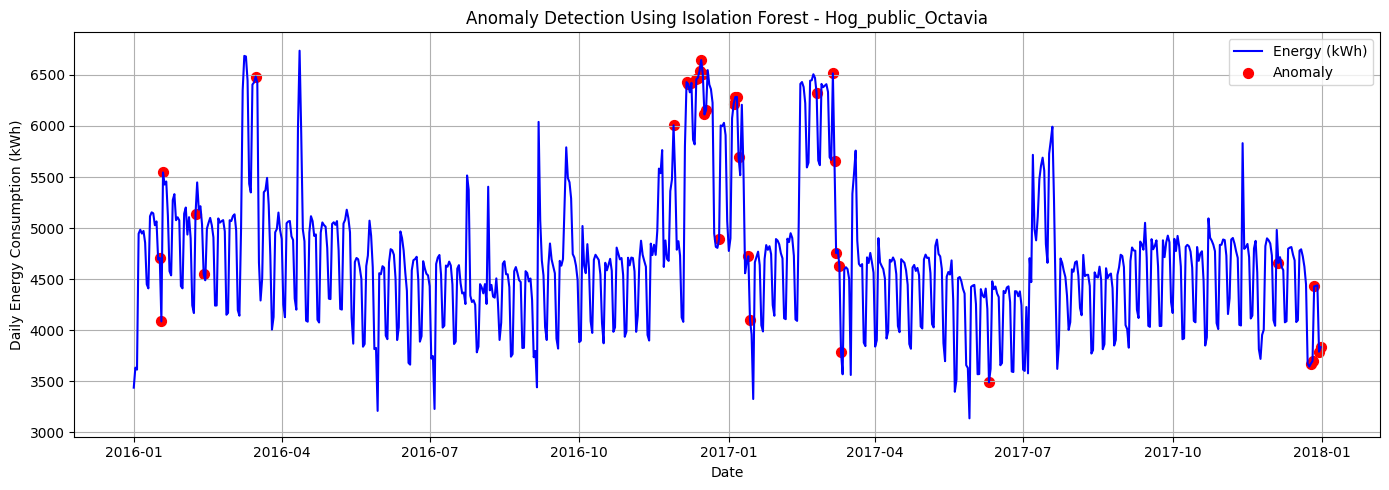

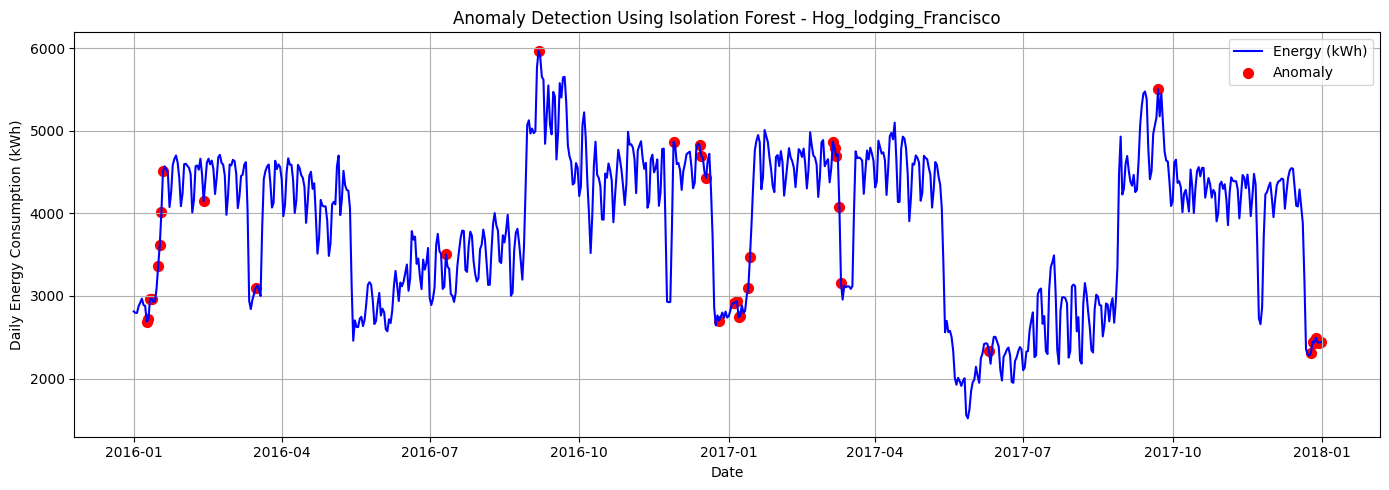

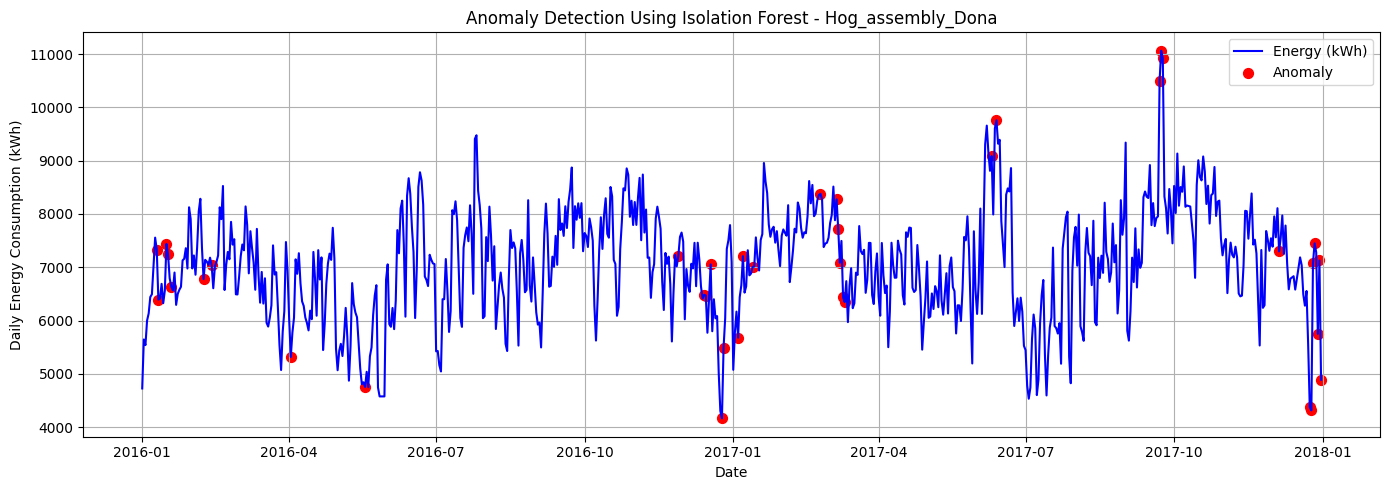

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Step 1: Daily aggregation
daily_df = df_long.groupby(['building_id', pd.Grouper(key='timestamp', freq='D')]).agg({
    'value': 'sum',
    'airTemperature': 'mean',
    'dewTemperature': 'mean',
    'windSpeed': 'mean',
    'seaLvlPressure': 'mean'
}).reset_index()

# Step 2: Process each building
top_5_buildings = ['Hog_office_Lizzie', 'Hog_education_Jewel', 'Hog_public_Octavia',
                   'Hog_lodging_Francisco', 'Hog_assembly_Dona']

for building_id in top_5_buildings:
    building_df = daily_df[daily_df['building_id'] == building_id].copy()

    # Drop missing values
    building_df = building_df.dropna()

    # Use only numerical features for detection
    feature_cols = ['value', 'airTemperature', 'dewTemperature', 'windSpeed', 'seaLvlPressure']
    X = building_df[feature_cols]

    # Fit Isolation Forest
    iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    building_df['anomaly'] = iso_forest.fit_predict(X)
    building_df['anomaly'] = building_df['anomaly'].map({1: 0, -1: 1})  # 1 = anomaly

    # Plot results
    plt.figure(figsize=(14, 5))
    plt.plot(building_df['timestamp'], building_df['value'], label='Energy (kWh)', color='blue')

    # Red dots for anomalies
    anomaly_points = building_df[building_df['anomaly'] == 1]
    plt.scatter(anomaly_points['timestamp'], anomaly_points['value'],
                color='red', s=50, label='Anomaly', marker='o')

    plt.title(f"Anomaly Detection Using Isolation Forest - {building_id}")
    plt.xlabel("Date")
    plt.ylabel("Daily Energy Consumption (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# AutoEncoder Anomaly Detection

In [35]:
# Convert timestamp to date
df_long['date'] = df_long['timestamp'].dt.date

# Daily aggregation
daily_df = df_long.groupby(['building_id', 'date']).agg({
    'value': 'sum',
    'airTemperature': 'mean',
    'dewTemperature': 'mean',
    'precipDepth1HR': 'sum',
    'windSpeed': 'mean',
    'seaLvlPressure': 'mean'
}).reset_index()


In [36]:
# Choose one building
building_df = daily_df[daily_df['building_id'] == 'Hog_assembly_Dona'].copy()
building_df.set_index('date', inplace=True)


In [37]:
!pip install tensorflow


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


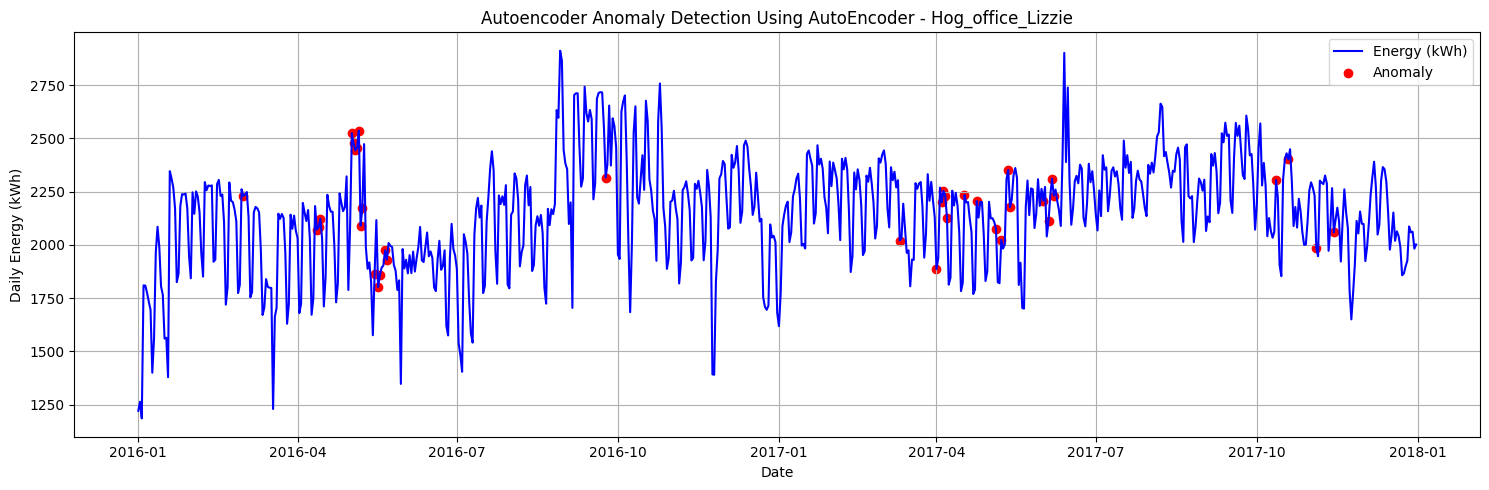

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


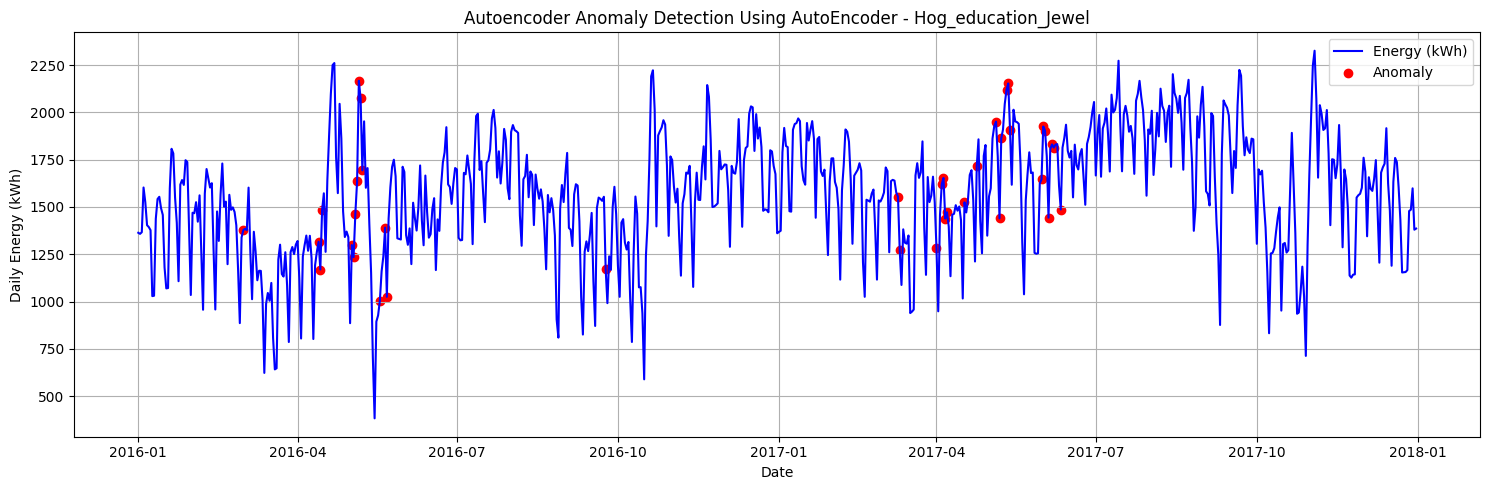

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


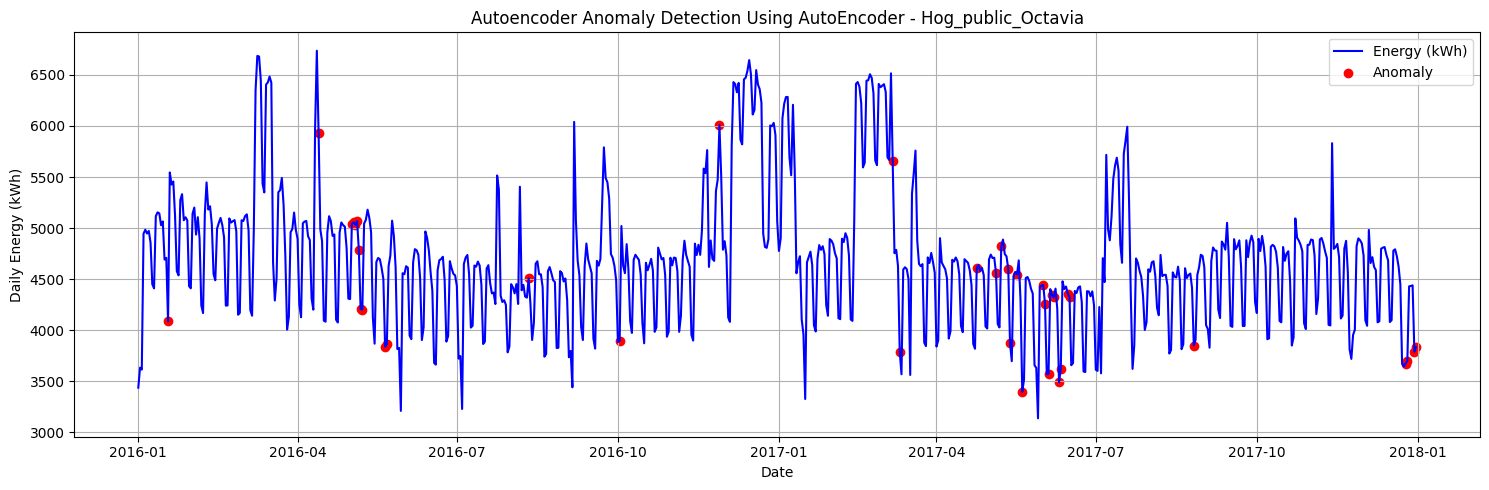

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


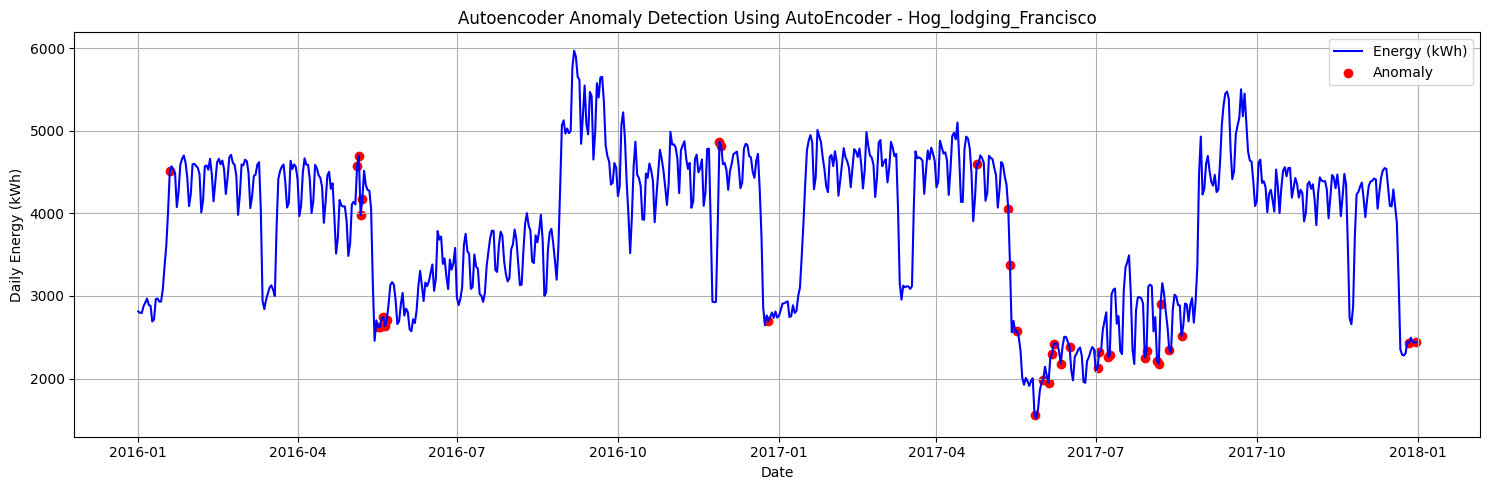

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


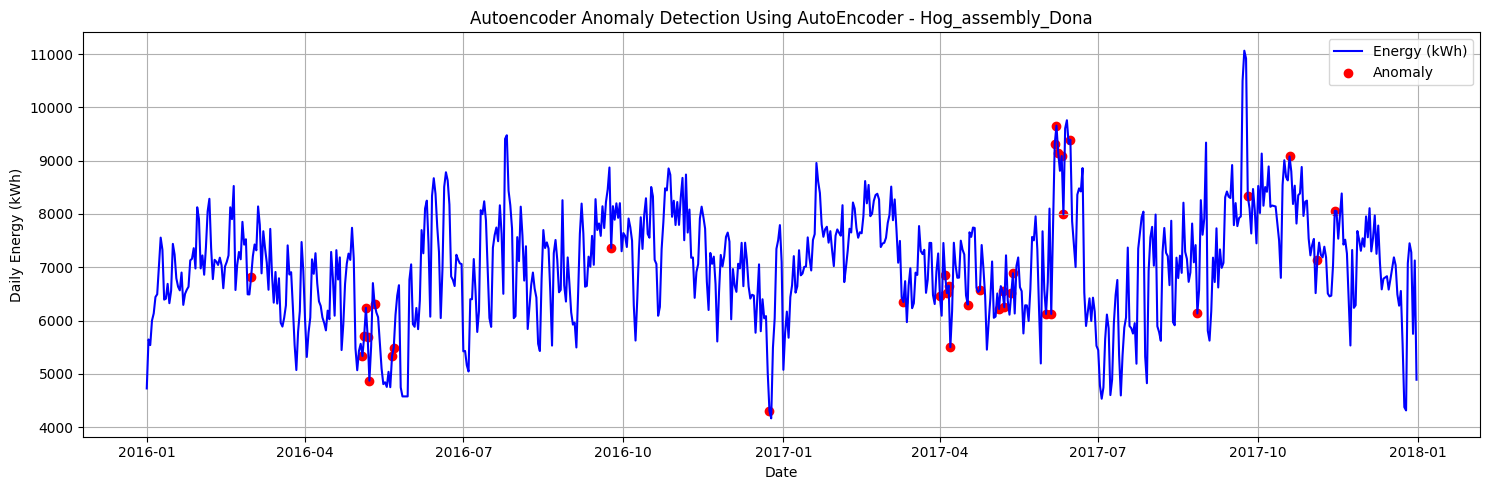

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Assume df_long already contains the full merged dataset including weather
# We start by filtering for a specific building
def run_autoencoder_anomaly_detection(building_id, df_long):
    # Filter for one building
    df_building = df_long[df_long['building_id'] == building_id].copy()

    # Daily aggregation
    df_building['date'] = df_building['timestamp'].dt.date
    daily_df = df_building.groupby('date').agg({
        'value': 'sum',
        'airTemperature': 'mean',
        'dewTemperature': 'mean',
        'precipDepth1HR': 'sum',
        'windSpeed': 'mean',
        'seaLvlPressure': 'mean'
    }).dropna()

    # Normalize
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(daily_df)

    # Define autoencoder model
    input_dim = scaled_data.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)

    autoencoder.compile(optimizer='adam', loss='mse')

    # Train autoencoder
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    autoencoder.fit(scaled_data, scaled_data, epochs=100, batch_size=16, shuffle=True, callbacks=[early_stop], verbose=0)

    # Reconstruction and anomaly score
    reconstructed = autoencoder.predict(scaled_data)
    mse = np.mean(np.square(scaled_data - reconstructed), axis=1)
    threshold = np.percentile(mse, 95)
    anomalies = mse > threshold

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(daily_df.index, daily_df['value'], label='Energy (kWh)', color='blue')
    plt.scatter(daily_df.index[anomalies], daily_df['value'][anomalies], color='red', label='Anomaly')
    plt.title(f"Autoencoder Anomaly Detection Using AutoEncoder - {building_id}")
    plt.xlabel("Date")
    plt.ylabel("Daily Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run for all top 5 buildings
for building in ['Hog_office_Lizzie', 'Hog_education_Jewel', 'Hog_public_Octavia',
                 'Hog_lodging_Francisco', 'Hog_assembly_Dona']:
    run_autoencoder_anomaly_detection(building, df_long)


In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

# df_long already contains all data including weather, and aggregated by
# building_id and date
top_5_buildings = ['Hog_office_Lizzie', 'Hog_education_Jewel', 'Hog_public_Octavia',
                   'Hog_lodging_Francisco', 'Hog_assembly_Dona']

results = []

for b in top_5_buildings:
    # Filter
    df_b = df_long[df_long['building_id'] == b].copy()

    # Feature Engineering
    df_b['lag_1'] = df_b['value'].shift(1)
    df_b['rolling_mean_7'] = df_b['value'].rolling(window=7).mean()
    df_b['dayofweek'] = df_b['timestamp'].dt.dayofweek
    df_b['month'] = df_b['timestamp'].dt.month

    features = ['value', 'lag_1', 'rolling_mean_7', 'dayofweek', 'month',
                'airTemperature', 'dewTemperature', 'windSpeed']

    df_b = df_b.dropna(subset=features)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_b[features])

    # Autoencoder
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_scaled.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(X_scaled.shape[1], activation='linear'))

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

    # Predictions
    X_pred = model.predict(X_scaled)
    mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)
    threshold = np.percentile(mse, 95)  # Top 5% as anomaly

    df_b['reconstruction_error'] = mse
    df_b['is_anomaly'] = (mse > threshold).astype(int)

    # First, assign 'date' column
    df_b['date'] = df_b['timestamp'].dt.date

    # A day is anomalous if **any hour in that day** is anomalous
    daily_anomalies = df_b.groupby('date')['is_anomaly'].max()

    # Total unique days
    total_days = daily_anomalies.shape[0]
    anomaly_days = daily_anomalies.sum()
    anomaly_rate = round((anomaly_days / total_days) * 100, 2)

   # Append metrics (based on daily-level anomaly detection)
    results.append({
    'Building': b,
    'Total Days': int(total_days),
    'Anomalies Detected': int(anomaly_days),
    'Anomaly Rate (%)': anomaly_rate
    })


# Final summary
df_ae_results = pd.DataFrame(results)
print(df_ae_results)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                Building  Total Days  Anomalies Detected  Anomaly Rate (%)
0      Hog_office_Lizzie         731                 248             33.93
1    Hog_education_Jewel         731                 160             21.89
2     Hog_public_Octavia         731                 181             24.76
3  Hog_lodging_Francisco         731                 171             23.39
4      Hog_assembly_Dona         731                 160             21.89


# Deployment

In [40]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment="Real-Time Fraud Detection Workflow")

# Set graph attributes for better aesthetics
dot.attr(rankdir='LR', size='8,5')

# Nodes for each stage
dot.node('A', 'Data Acquisition\n(Transaction Dataset)', shape='box', style='filled', color='lightblue')
dot.node('B', 'Data Preprocessing\n(Cleaning, Encoding, SMOTE)', shape='box', style='filled', color='lightblue')
dot.node('C', 'Model Selection & Training\n(Random Forest, LightGBM, XGBoost)', shape='box', style='filled', color='lightgreen')
dot.node('D', 'Model Evaluation\n(Accuracy, Recall, AUC, F1-score)', shape='box', style='filled', color='lightgreen')
dot.node('E', 'Flask Integration\n(API for Real-Time Prediction)', shape='box', style='filled', color='orange')
dot.node('F', 'Testing & Deployment\n(Functional, Performance, Stress)', shape='box', style='filled', color='lightpink')

# Edges to connect workflow
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])



In [41]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Create summary list
summary = []
df_anomaly_list = []

# Use same top 5 buildings
top_5_buildings = ['Hog_office_Lizzie', 'Hog_education_Jewel', 'Hog_public_Octavia',
                   'Hog_lodging_Francisco', 'Hog_assembly_Dona']

for building_id in top_5_buildings:
    building_df = daily_df[daily_df['building_id'] == building_id].dropna().copy()

    # Select features for anomaly detection
    feature_cols = ['value', 'airTemperature', 'dewTemperature', 'windSpeed', 'seaLvlPressure']
    X = building_df[feature_cols]

    # Apply Isolation Forest
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=40)
    preds = iso_forest.fit_predict(X)
    building_df['anomaly'] = (preds == -1).astype(int)

    # Append building's anomaly results to list
    df_anomaly_list.append(building_df[['date', 'value', 'building_id', 'anomaly']])

    # Summarize
    total_days = len(building_df)
    anomaly_days = building_df['anomaly'].sum()
    anomaly_rate = round((anomaly_days / total_days) * 100, 2)

    summary.append({
        'Building': building_id,
        'Total Days': total_days,
        'Anomalies Detected': anomaly_days,
        'Anomaly Rate (%)': anomaly_rate
    })

# Create anomaly DataFrame for dashboard
df_anomaly = pd.concat(df_anomaly_list, ignore_index=True)
df_anomaly['date'] = pd.to_datetime(df_anomaly['date'])

# Create and display summary table
summary_df = pd.DataFrame(summary)
print(summary_df)


                Building  Total Days  Anomalies Detected  Anomaly Rate (%)
0      Hog_office_Lizzie         731                 116             15.87
1    Hog_education_Jewel         731                 123             16.83
2     Hog_public_Octavia         731                 122             16.69
3  Hog_lodging_Francisco         731                 116             15.87
4      Hog_assembly_Dona         731                 108             14.77


In [42]:
print(df_anomaly.tail())

           date     value        building_id  anomaly
3650 2017-12-27  7448.786  Hog_assembly_Dona        1
3651 2017-12-28  7278.370  Hog_assembly_Dona        1
3652 2017-12-29  5749.868  Hog_assembly_Dona        1
3653 2017-12-30  7126.473  Hog_assembly_Dona        1
3654 2017-12-31  4889.210  Hog_assembly_Dona        1


**Merge Anomalies into df_predictions**


Convert and rename for consistency

In [43]:
df_anomaly['date'] = pd.to_datetime(df_anomaly['date'])
df_predictions['timestamp'] = pd.to_datetime(df_predictions['timestamp'])

# Extract just date for alignment (ignore time)
df_predictions['date'] = df_predictions['timestamp'].dt.date
df_anomaly['date'] = df_anomaly['date'].dt.date

# Rename column to match
df_anomaly = df_anomaly.rename(columns={'building_id': 'building'})


***Merge on date and building***

In [44]:
df_predictions = df_predictions.merge(
    df_anomaly[['date', 'building', 'anomaly']],
    on=['date', 'building'],
    how='left'
)

# Fill missing anomaly flags with 0
df_predictions['anomaly'] = df_predictions['anomaly'].fillna(0).astype(int)


In [45]:
df_predictions.drop(columns=['date'], inplace=True)


In [46]:
pip install dash pandas plotly flask-ngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 13.9 MB/s eta 0:00:00


In [47]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
import pandas as pd

# Load your prepared data
df = df_predictions.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
anomaly_df = df_anomaly.copy()
anomaly_df['date'] = pd.to_datetime(anomaly_df['date'])

# Start the app
app = dash.Dash(__name__)
app.title = 'Energy Forecast Dashboard'

# Layout
app.layout = html.Div([
    html.H1("Energy Forecast Dashboard - By Deborah Ahonsi", style={'textAlign': 'left', 'fontWeight': 'bold'}),

    dcc.Dropdown(
        id='building-dropdown',
        options=[{'label': bld, 'value': bld} for bld in df['building'].unique()],
        value=df['building'].unique()[0],
        style={'width': '50%'}
    ),

    html.Div([
        dcc.Checklist(
            id='anomaly-toggle',
            options=[{'label': 'Show anomalies', 'value': 'anomaly'}],
            value=[],
            labelStyle={'display': 'inline-block', 'margin-right': '20px'}
        ),
        dcc.Checklist(
            id='temperature-toggle',
            options=[{'label': 'Overlay air temperature', 'value': 'temp'}],
            value=[],
            labelStyle={'display': 'inline-block'}
        )
    ], style={'margin': '10px 0'}),

    dcc.Graph(id='energy-forecast-graph')
])

# Callback
@app.callback(
    Output('energy-forecast-graph', 'figure'),
    Input('building-dropdown', 'value'),
    Input('anomaly-toggle', 'value'),
    Input('temperature-toggle', 'value')
)
def update_graph(selected_building, show_anomalies, show_temp):
    bld_df = df[df['building'] == selected_building].sort_values('timestamp')

    fig = go.Figure()

    # Predicted
    fig.add_trace(go.Scatter(
        x=bld_df['timestamp'],
        y=bld_df['predicted'],
        mode='lines',
        name='Predicted Usage',
        line=dict(color='red'),
        hoverinfo='x+y'
    ))

    # Actual
    fig.add_trace(go.Scatter(
        x=bld_df['timestamp'],
        y=bld_df['actual'],
        mode='lines',
        name='Actual Usage',
        line=dict(color='lightblue'),
        hoverinfo='x+y'
    ))

    # Anomalies
    if 'anomaly' in show_anomalies:
        bld_anomalies = anomaly_df[anomaly_df['building_id'] == selected_building]
        merged = pd.merge(bld_df, bld_anomalies, how='inner', left_on='timestamp', right_on='date')
        fig.add_trace(go.Scatter(
            x=merged['timestamp'],
            y=merged['actual'],
            mode='markers',
            name='Anomalies',
            marker=dict(color='black', size=8, symbol='x'),
            hoverinfo='x+y'
        ))

    # Temperature overlay
    if 'temp' in show_temp:
        fig.add_trace(go.Scatter(
            x=bld_df['timestamp'],
            y=bld_df['airTemperature'],
            mode='lines',
            name='Air Temperature',
            line=dict(color='brown', dash='dot'),
            yaxis='y2'
        ))
        fig.update_layout(
            yaxis2=dict(
                title='Air Temperature (°C)',
                overlaying='y',
                side='right',
                showgrid=False
            )
        )

    # Layout styling
    fig.update_layout(
        title=f'Predictions for {selected_building}',
        xaxis_title='Date',
        yaxis_title='Predicted Usage',
        template='plotly_white',
        hovermode='x unified',
        height=500
    )

    return fig

# Run server
if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>

In [48]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
import pandas as pd

# Load your prepared data
df = df_predictions.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
anomaly_df = df_anomaly.copy()
anomaly_df['date'] = pd.to_datetime(anomaly_df['date'])

# Start the app
app = dash.Dash(__name__)
app.title = 'Energy Forecast Dashboard'

# Layout
app.layout = html.Div([
    html.H1("Energy Forecast Dashboard - By Deborah Ahonsi", style={'textAlign': 'left', 'fontWeight': 'bold'}),

    dcc.Dropdown(
        id='building-dropdown',
        options=[{'label': bld, 'value': bld} for bld in df['building'].unique()],
        value=df['building'].unique()[0],
        style={'width': '50%'}
    ),

    html.Div([
        dcc.Checklist(
            id='anomaly-toggle',
            options=[{'label': 'Show anomalies', 'value': 'anomaly'}],
            value=[],
            labelStyle={'display': 'inline-block', 'margin-right': '20px'}
        ),
        dcc.Checklist(
            id='temperature-toggle',
            options=[{'label': 'Overlay air temperature', 'value': 'temp'}],
            value=[],
            labelStyle={'display': 'inline-block'}
        )
    ], style={'margin': '10px 0'}),

    dcc.Graph(id='energy-forecast-graph')
])

# Callback
@app.callback(
    Output('energy-forecast-graph', 'figure'),
    Input('building-dropdown', 'value'),
    Input('anomaly-toggle', 'value'),
    Input('temperature-toggle', 'value')
)
def update_graph(selected_building, show_anomalies, show_temp):
    bld_df = df[df['building'] == selected_building].sort_values('timestamp')

    fig = go.Figure()

    # Predicted
    fig.add_trace(go.Scatter(
        x=bld_df['timestamp'],
        y=bld_df['predicted'],
        mode='lines',
        name='Predicted Usage',
        line=dict(color='red'),
        hoverinfo='x+y'
    ))

    # Actual
    fig.add_trace(go.Scatter(
        x=bld_df['timestamp'],
        y=bld_df['actual'],
        mode='lines',
        name='Actual Usage',
        line=dict(color='skyblue'),
        hoverinfo='x+y'
    ))

    # Anomalies
    if 'anomaly' in show_anomalies:
        bld_anomalies = anomaly_df[anomaly_df['building'] == selected_building]
        bld_anomalies['date'] = pd.to_datetime(bld_anomalies['date']).dt.normalize()
        bld_df['timestamp'] = pd.to_datetime(bld_df['timestamp']).dt.normalize()

        merged = pd.merge(bld_df, bld_anomalies, how='inner', left_on='timestamp', right_on='date')

        if not merged.empty:
            fig.add_trace(go.Scatter(
                x=merged['timestamp'],
                y=merged['actual'],
                mode='markers',
                name='Anomalies',
                marker=dict(color='white', size=5, symbol='x'),
                hoverinfo='x+y'
            ))

    # Temperature overlay
    if 'temp' in show_temp:
        fig.add_trace(go.Scatter(
            x=bld_df['timestamp'],
            y=bld_df['airTemperature'],
            mode='lines',
            name='Air Temperature',
            line=dict(color='brown', dash='dot'),
            yaxis='y2'
        ))
        fig.update_layout(
            yaxis2=dict(
                title='Air Temperature (°C)',
                overlaying='y',
                side='right',
                showgrid=False
            )
        )

    # Layout styling
    fig.update_layout(
        title=f'Predictions for {selected_building}',
        xaxis_title='Date',
        yaxis_title='Predicted Usage',
        hovermode='x unified',
        height=500,
        paper_bgcolor='white',     # Background of entire figure
        plot_bgcolor='white',      # Background of plotting area
        font=dict(color='black'),    # Text color
        legend=dict(
            bgcolor='rgba(255, 255, 255, 0.5)',  # Slightly transparent legend background
            bordercolor='black',
            borderwidth=1
        )
    )

    return fig

# Run server
if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>